In [35]:
# %load estimator.py
import numpy as np


import matplotlib.pyplot as plot
from model import *
from diffsolver import *


class PredatorPrey(OdeSolver):
    def __init__(self, time_info, initial_values, a, b, c, d):
        OdeSolver.__init__(self, time_info, initial_values)
        self.a = a
        self.b = b
        self.c = c
        self.d = d

    def equation(self, t, x):
        x1 = self.a * x[0] - self.b * x[0] * x[1]
        x2 = -self.c * x[1] + self.d * x[0] * x[1]
        return np.array([x1, x2])


class Estimator(Grid4DModel):

    # abcd: tuple of ranges of parameters
    # steps: steps
    # initial_value: tuple of initial value
    def __init__(self, abcd, steps, initial_value, known_error):
        grid_a = GridInfo(start=0.0, end=abcd[0], steps=steps)
        grid_b = GridInfo(start=0.0, end=abcd[1], steps=steps)
        grid_c = GridInfo(start=0.0, end=abcd[2], steps=steps)
        grid_d = GridInfo(start=0.0, end=abcd[3], steps=steps)

        Grid4DModel.__init__(self, [grid_a, grid_b, grid_c, grid_d])

        self.abcd = abcd
        self.initial_value = np.array([initial_value[0], initial_value[1]])
        self.known_error = known_error

    # data: [0] = time, [1,2] = observed value
    def likelihood(self, data, hypothesis):
        time_info = OdeTime(0.0, data[0], 1000)
        solver = PredatorPrey(time_info, self.initial_value, hypothesis[0], hypothesis[1], hypothesis[2], hypothesis[3])
        solver.solve()
        y = solver.ode_output.results[-1]
        diff = y - data[1:2]
        diff = -(diff**2)
        diff = diff.sum() / (self.known_error ** 2)
        return np.exp(-diff)
    
    def log_likelihood(self, data, hypothesis):
        time_info = OdeTime(0.0, data[0], 500)
        solver = PredatorPrey(time_info, self.initial_value, hypothesis[0], hypothesis[1], hypothesis[2], hypothesis[3])
        solver.solve()
        y = solver.ode_output.results[-1]
        diff = (y - data[1:2])**2
        diff = diff / (2.0 * (self.known_error ** 2))
        return -diff.sum()/2.0
    
    def log_update_all(self, data):
        temp_dict = {}
        max_logprob = 0.0
        for hypo in self.prob_dict:
            p = self.prob_dict[hypo]
            if p < 0.0001:
                continue
            log_prob = self.log_likelihood(data, hypo)
            temp_dict[hypo] = log_prob + np.log(p)
            if log_prob > max_logprob:
                max_logprob = log_prob
        for hypo in self.prob_dict:
            if hypo in temp_dict:
                self.prob_dict[hypo] = np.exp(temp_dict[hypo] - max_logprob)
            else:
                self.prob_dict[hypo] = 0.0
            #print(self.prob_dict[hypo])
        self.normalize()

In [12]:
# %load simulator.py
import numpy as np


class OdeSimulator:

    def __init__(self, odesolver, stdev=1.0):
        self.odesolver = odesolver
        self.stdev = stdev
        self.odesolver.solve()

    def simulate(self, t):
        return self.odesolver.value(t) + np.random.normal(scale=self.stdev)

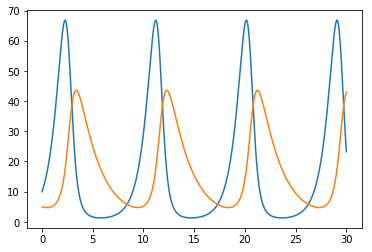

In [13]:
time_info = OdeTime(0.0, 30.0, 10001)
answer = PredatorPrey(time_info, np.array([10.0, 5.0]), 1.4, 0.08, 0.5, 0.03)
answer.solve()
answer.print_graph()

In [14]:
simulator = OdeSimulator(answer, stdev=0.01)
simulator.simulate(3)

array([ 34.2548406 ,  39.98552951])

In [36]:
estimator = Estimator((1.5, 0.1, 0.7, 0.05), 10, [10.0, 5.0], 1)
estimator.normalize()

In [37]:
def make_data(t):
    y = simulator.simulate(t)
    return (t, y[0], y[1])

def guess(t):
    d = make_data(t)
    print(d)
    estimator.log_update_all(d)
    a = estimator.marginal_distribution(0)
    b = estimator.marginal_distribution(1)
    c = estimator.marginal_distribution(2)
    d = estimator.marginal_distribution(3)
    plot.plot(a[:, 0], a[:, 1], 'r')
    plot.plot(b[:, 0], b[:, 1], 'g')
    plot.plot(c[:, 0], c[:, 1], 'b')
    plot.plot(d[:, 0], d[:, 1], 'k')
    plot.show()

(3.0, 34.25525274809975, 39.985941663557561)


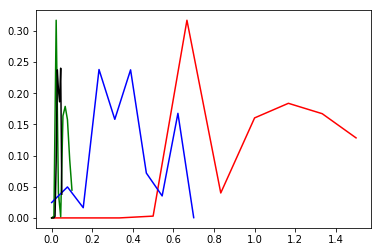

In [38]:
guess(3.0)

(5.0, 1.614475959942127, 24.961287898810699)


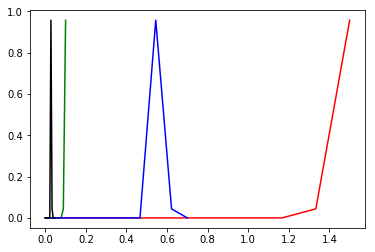

In [39]:
guess(5.0)

(8.4, 5.9396673801057362, 5.755136442976668)


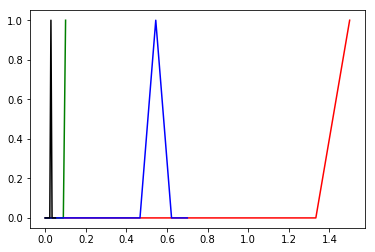

In [40]:
guess(8.4)

In [43]:
mymax = (0.0, 0.0, 0.0, 0.0)
myp = 0.0
for hypo in estimator.prob_dict:
    if myp < estimator.prob_dict[hypo]:
        mymax = hypo
        myp = estimator.prob_dict[hypo]

realvalue = (1.4, 0.08, 0.5, 0.03)
print("Estimated Parameters = " + str(mymax))

Estimated Parameters = (1.5, 0.10000000000000001, 0.54444444444444451, 0.02777777777777778)


In [49]:
mymax_arr = np.array(mymax)
realval_arr = np.array(realvalue)
err_arr = np.abs(mymax_arr-realval_arr)/realval_arr
print(err_arr * 100)

[  7.14285714  25.           8.88888889   7.40740741]
